In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
img = cv2.imread("../images/output.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgHSV = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

plt.imshow(img)
plt.show()
#low_bound = cv2.Scalar(200,200,200)
#up_bound = cv2.Scalar(255,255,255)
#ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ret, thresh = cv2.threshold(gray,0,180,cv2.THRESH_BINARY)



error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


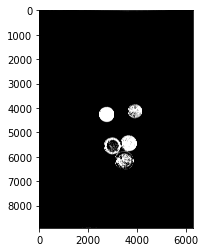

In [ ]:
mask = cv2.inRange(imgHSV,(0,0,0),(255,120,255))
mask = cv2.bitwise_not(mask)


plt.imshow(mask,cmap='gray')
plt.show()

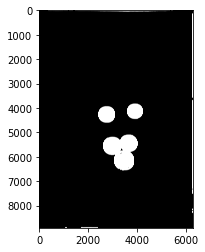

In [ ]:
kernel = np.ones((5,5), np.uint8)
morf = cv2.erode(mask, kernel, iterations=5)
morf = cv2.dilate(mask, kernel, iterations=15)

plt.imshow(morf,cmap='gray')
plt.show()

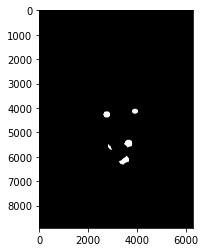

In [ ]:
opening = cv2.morphologyEx(morf,cv2.MORPH_OPEN,kernel, iterations = 3)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,0)
ret, sure_fg = cv2.threshold(dist_transform,0.6*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(sure_fg,cmap='gray')
plt.show()

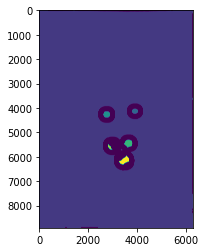

In [ ]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers)
plt.show()

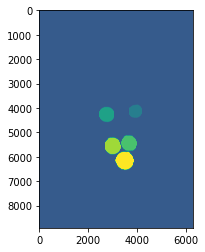

True

In [ ]:
markers = cv2.watershed(img,markers)
#img[markers == -1] = [255,0,0]
plt.imshow(markers)
plt.show()
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
cv2.imwrite("segmented.png", img)


(8910, 6300)


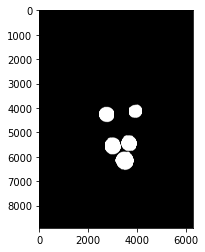

In [ ]:
print(markers.shape)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
result = img.copy()
result[markers < 2] = [0,0,0]
result[markers >= 2] = [255,255,255]


plt.imshow(result, cmap='gray')
plt.show()

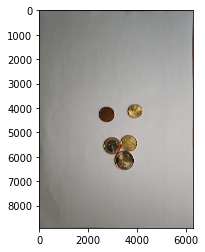

In [ ]:
resultbw = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
contours, _ = cv2.findContours(resultbw,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE )
drawing = img.copy()
#print(contours)

for i in range(len(contours)):
    cv2.drawContours(drawing, contours, i, (255,0,0), 5)

plt.imshow(drawing)
plt.show()

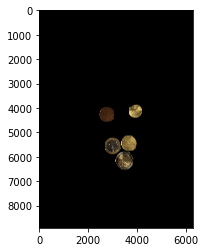

In [ ]:
segmented = cv2.bitwise_and(img, img, mask=resultbw)

plt.imshow(segmented)
plt.show()

In [12]:
# Blob detection of coins - process one by one
nCoins = np.max(markers) - 1

coins = []

for i in range(nCoins):
    c = (markers==i+2)
    #c = cv2.cvtColor(c, cv2.COLOR_RGB2GRAY)
    coins.append(np.uint8(c))


In [13]:
coins[0].size
img.size

168399000

0 (21.581026389556968, 144.60438056693593, 153.59638988870276, 0.0)
1 (13.159051681507407, 185.87316511346705, 65.8982353823232, 0.0)
2 (20.762009653170608, 150.03644026456837, 141.9085009104764, 0.0)
3 (18.969777956008702, 114.64697367553671, 74.99438572590037, 0.0)
4 (18.773968772061725, 113.78065719865407, 95.11128735020951, 0.0)


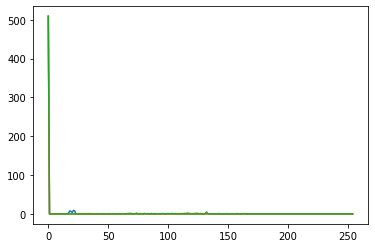

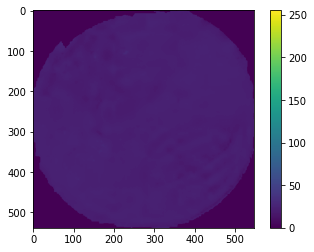

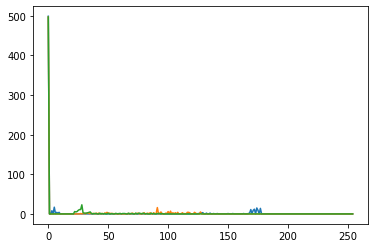

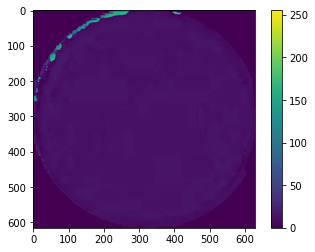

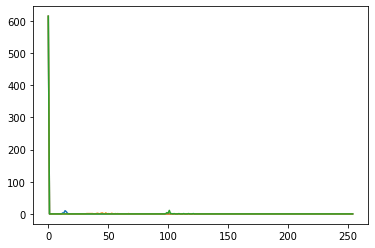

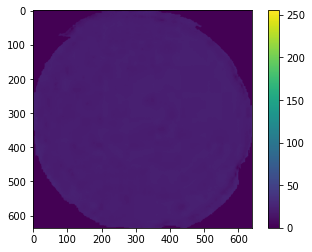

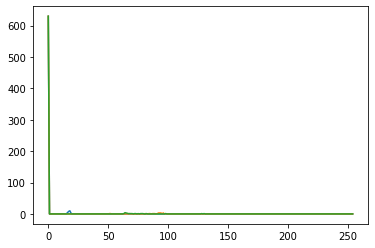

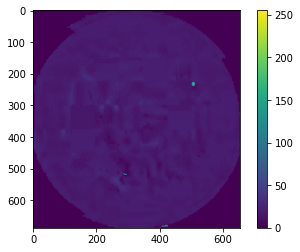

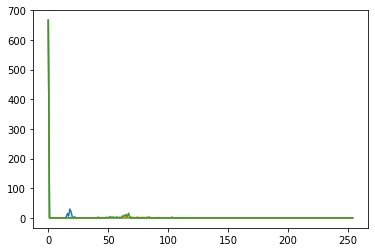

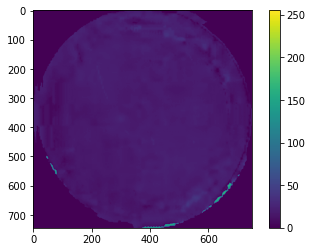

In [43]:
# Recognition of coins
# yellow -> 180º
for i in range(nCoins):
    coinImg = cv2.bitwise_and(img, img, mask=coins[i])
    count, hier = cv2.findContours(coins[i], 1,2)
    x,y,w,h = cv2.boundingRect(count[0])
    #coinImg = coinImg[y:y+h,x:x+w]
    coinImg = img[y:y+h,x:x+w]
    coinImg = cv2.cvtColor(coinImg, cv2.COLOR_RGB2HSV)
    h,s,v = cv2.split(coinImg)

    histH = cv2.calcHist(h, [0], None, [255], [0, 255])
    histS = cv2.calcHist(s, [0], None, [255], [0, 255])
    histV = cv2.calcHist(v, [0], None, [255], [0, 255])
    
    plt.figure()
    plt.plot(histH)
    plt.plot(histS)
    plt.plot(histV)


    plt.figure()
    plt.imshow(h, vmin=0, vmax=255)
    plt.colorbar()

    mask = coinImg.copy()
    mask = cv2.cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    (mask > 1).astype(np.uint8)
    print(i, cv2.mean(coinImg,mask=mask))

In [ ]:

mask = np.zeros([h.shape[0], h.shape[1], 1], 'uint8')
mask = np.array((h.shape[0], h.shape[1], 1), np.uint8)
mask = cv2.threshold(h, 1,255,cv2.THRESH_BINARY)
mask[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [36]:
mask = coinImg.copy()

mask = cv2.cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

(mask > 1).astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)